In [20]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math
import scipy


In [21]:
with open('val_err_wo_lr_decay.json') as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 1e-3
patience = 15
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval


<IPython.core.display.Javascript object>


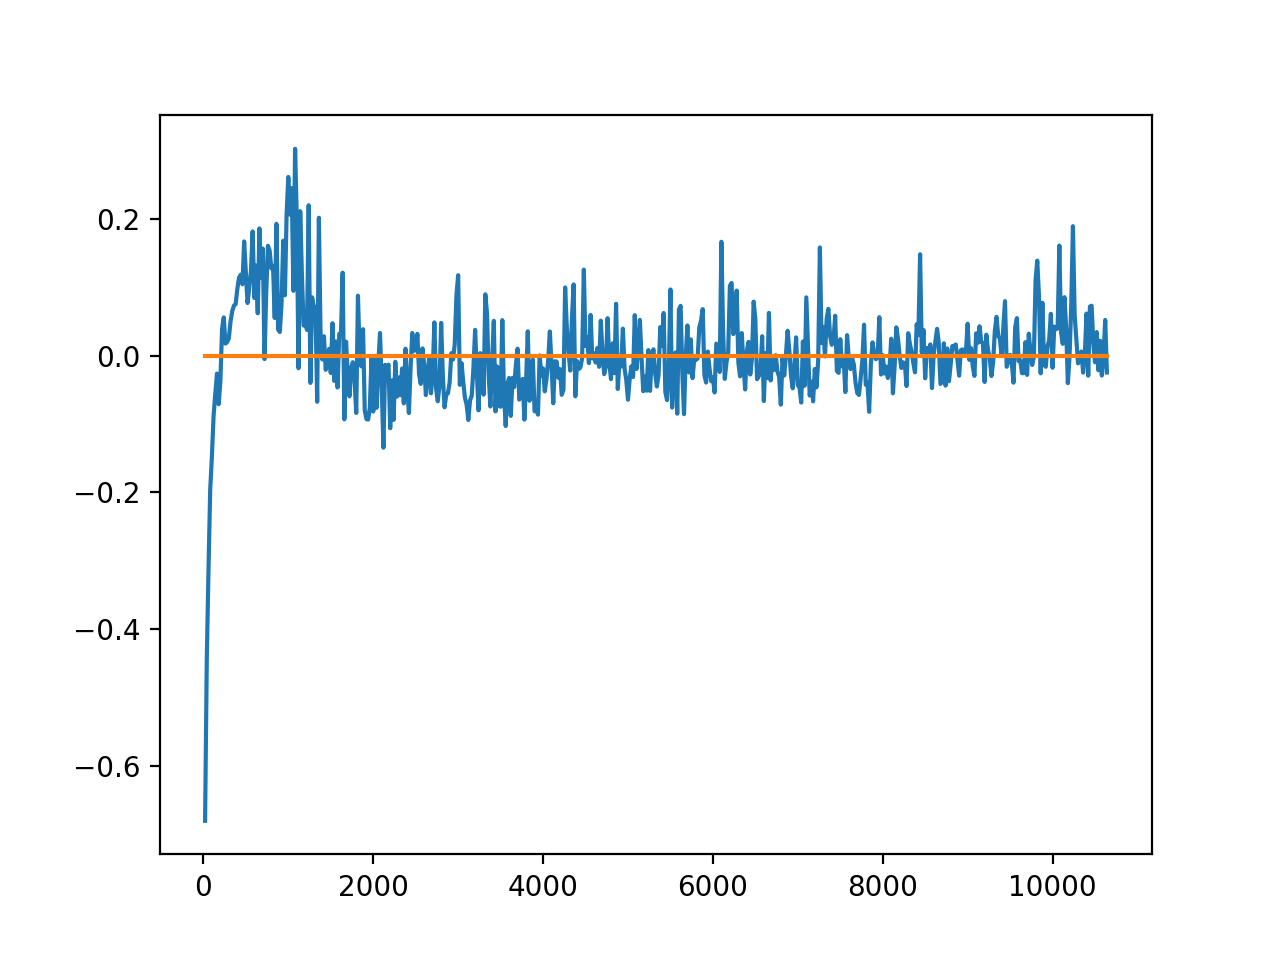

In [22]:
plt.figure()

whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

<IPython.core.display.Javascript object>


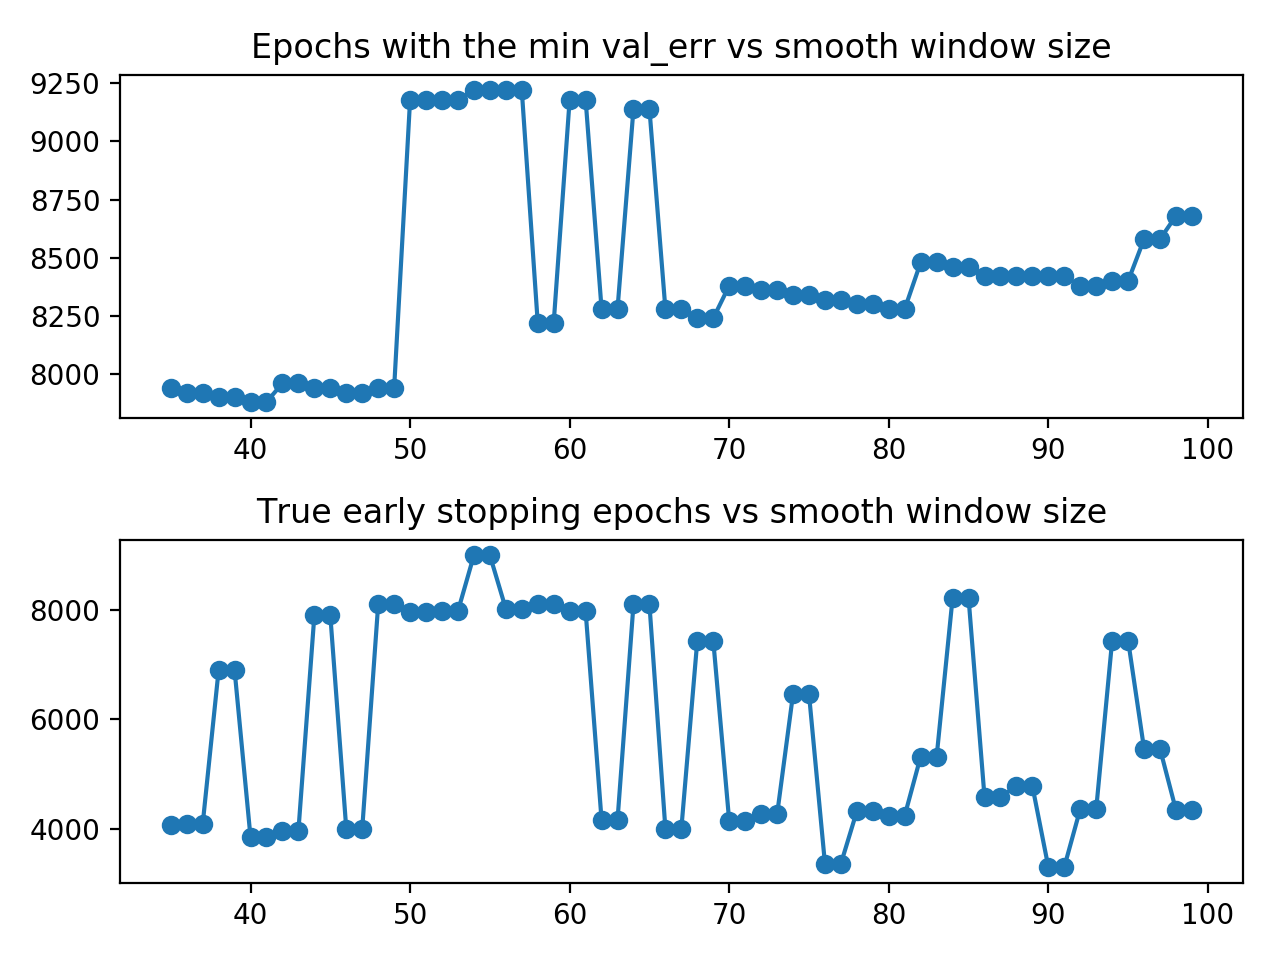

In [23]:
minEpochs = []
earlyStoppingSteps = []
x = range(35,100)
for i in x:
    smoothed_val_err_ = smooth_by_linear_filter(val_err, i)
#     print(smoothed_val_err_)
    minEpochs.append((np.argmin(smoothed_val_err_)+1)*20)
    earlyStoppingSteps.append(early_stopping_step(val_err, min_delta, patience, i, num_epochs_between_eval))


fig = plt.figure()
ax = plt.subplot(212)
ax.plot(x, earlyStoppingSteps, '-o')
ax.set_title('True early stopping epochs vs smooth window size')

ax = plt.subplot(211)
ax.plot(x, minEpochs, '-o')
ax.set_title('Epochs with the min val_err vs smooth window size')

fig.tight_layout()

In [24]:
smooth_win_size = 50
smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)

minEpoch = (np.argmin(smoothed_val_err)+1)*20
print(minEpoch, np.min(smoothed_val_err), len(smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, smoothed_val_err[earlyStoppingStep//20+1])

weights = np.ones(len(smoothed_val_err))
predictedEarlyStoppingStep, a, b = early_stopping_prediction(steps[:len(smoothed_val_err)], smoothed_val_err, min_delta, patience, weights=weights)

print(predictedEarlyStoppingStep)

9180 0.33029411820804366 507
7960 0.3326470594780118
2637.0


In [25]:
"""
Predict the early stopping epoch by "adding-noise" method
input: 
    a, b: y = ax^b
    var: the variance of unsmoothed data
    min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
    smooth_win_size: the window size for smoothing
    num_samples: how many samples to generate when using bootstrapping
    upper_limit: only consider the predicted epoch smaller than upper_limit
    lower_limit: only consider the predicted epoch larger than upper_limit
return:
    mean: mean of all predicted epochs
    stopping_epochs: all predicted epochs
    sample: one of the sythetic data
    smoothed_sample: smoothing the sythetic data
"""
def early_stopping_prediction_adding_noise(a,b,var,min_delta,patience, 
                                           num_epochs_between_eval,
                                           smooth_win_size,
                                           num_samples=100,
                                           upper_limit=2e4,
                                        lower_limit=0
                                          ):
    num_points = int(upper_limit // num_epochs_between_eval) # the number of noisy points we want to generate
    
    x = np.arange(1,num_points+1)*num_epochs_between_eval
    y = a*np.power(x,b)
        
    stopping_epochs = [] 
    for i in range(num_samples):
        noise = np.random.normal(0, np.sqrt(var), num_points)
        z = y + noise
        
        if i == 0:
            sample = z
            smoothed_sample = smooth_by_linear_filter(z, smooth_win_size)
        
        try:
            stopping_epochs.append(
                early_stopping_step(z, min_delta, patience, smooth_win_size, num_epochs_between_eval))
        except:
            continue
    
    return np.mean(stopping_epochs), np.array(stopping_epochs), sample, smoothed_sample

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
        
    
## deviation from mean (regard the regression line as mean)
var_calculate_start_index = 100
dev = (val_err-whole_a*np.power(steps[:len(val_err)],whole_b))[var_calculate_start_index:]
var = np.var(dev)

# dev_smoothed = (smoothed_val_err-a*np.power(steps[:len(smoothed_val_err)],b))[var_calculate_start_index:]
# var_smoothed = np.var(dev_smoothed)

# # print(var, var_smoothed)

# ## predict stopping epoch by bootstrapping
# fig = plt.figure()
# # upper_limit = len(val_err)*num_epochs_between_eval
# upper_limit = 1e5
# predictedEpochWithNoise, stopping_epochs, sample, smoothed_sample \
#                         = early_stopping_prediction_adding_noise(whole_a,whole_b,var,min_delta,patience,
#                                                                  num_epochs_between_eval,
#                                                                  smooth_win_size,
#                                                                  num_samples=1000,
#                                                                  upper_limit=upper_limit,
#                                                                 )

# ax = plt.subplot(211)
# x = np.arange(1,len(sample)+1)*num_epochs_between_eval
# ax.plot(x,sample)
# ax.plot(x[:len(smoothed_sample)],smoothed_sample)
# ax.set_xlim(-500,11200)
# ax.set_ylim(0.2,1)
# ax.set_title("Sythetic val_err")

# ax = plt.subplot(212)
# ax.plot(steps, val_err)
# ax.plot(steps[:len(smoothed_val_err)], smoothed_val_err)
# ax.set_xlim(-500,11200)
# ax.set_ylim(0.2,1)
# ax.set_title("True val_err")

# fig.tight_layout()

# # boxplot
# plt.figure()
# plt.boxplot(stopping_epochs, vert=False)

# # histogram
# plt.figure()
# plt.hist(stopping_epochs, bins='auto')

# ## CI
# _, CI_left, CI_right = mean_confidence_interval(stopping_epochs)

# print("mean predicted stopping step: {}".format(predictedEpochWithNoise))
# print("CI: ({},{})".format(CI_left, CI_right))

In [26]:
scipy.stats.norm(0,1).logcdf(np.array([0,1,2]))

array([-0.69314718, -0.17275378, -0.02301291])

In [43]:
"""
log cumulative probability of gaussian distribution at point x given mean mu and std sigma
"""
def _gaussian_cumulative_prob(x, mu, sigma):
    return scipy.stats.norm(mu, sigma).logcdf(x)

"""
use maximum likelihood to estimate the stopping epoch 
"""
def syn_early_stopping_predition_ml(a,b,var,
                                    min_delta,patience, 
                                    num_epochs_between_eval,
                                    smooth_win_size,
                                    upper_epoch_bound=2e4,
                                    lower_epoch_bound=None
                                   ):
    # default lower_limit is patience
    if lower_epoch_bound == None:
        # +1 becuase we want the point of lower-p-1
        # +1 again because the model didn't val at the beginning of training, so we don't want the result to be 0.
        lower_epoch_bound = (patience+2) * num_epochs_between_eval 
    
    # decide the actural win_size
    total_win, _ = actual_win_size(smooth_win_size)
    
    lower_point = int(lower_epoch_bound // num_epochs_between_eval)
    upper_point = int(upper_epoch_bound // num_epochs_between_eval)
    # we want to calculate the likelihood over [lower - p - 1, lower], ... , [upper-2-p, upper-1]
    # get the number of points from lower_point to upper_point - 1
    num_points = upper_point - lower_point # lower inclusive, upper exclusive
    
    # build a num_points X p+1 matrix to store all the log cumulative probability we later will use
    regression_values_needed = a * np.power(np.arange(lower_point-patience-1, upper_point-1) * num_epochs_between_eval, b)
    regression_values_needed2 = a * np.power(np.arange(lower_point-patience+total_win-1, upper_point-1+total_win) * num_epochs_between_eval, b)
    epsilons = total_win*min_delta - (regression_values_needed - regression_values_needed2)   
    epsilon_matrix = np.vstack(epsilons[i:patience+i] for i in range(num_points))
    prob_matrix1 = scipy.stats.norm(0, np.sqrt(2*var)).logsf(epsilon_matrix[:,0]).reshape(-1,1)
    print(prob_matrix1)
    prob_matrix2 = scipy.stats.norm(0, np.sqrt(2*var)).logcdf(epsilon_matrix[:,1:])
    print(prob_matrix2)
    prob_matrix = np.concatenate([prob_matrix1, prob_matrix2], 1)
    
    # get the ML point
    print(np.sum(prob_matrix, 1))
    pred_epoch = (np.argmax(np.sum(prob_matrix, 1)) + lower_point - patience) * num_epochs_between_eval
    
    return pred_epoch
    
    
    

    
predictedEpochWithNoise = syn_early_stopping_predition_ml(
                                whole_a,whole_b,var,
                                min_delta,patience,
                                smooth_win_size,
                                num_epochs_between_eval,
                                upper_epoch_bound=1e4
                                 )   
print(predictedEpochWithNoise)
    

[[-2.24020206e-23]
 [-1.77459877e-12]
 [-1.86281746e-08]
 [-2.23009071e-06]
 [-4.01692322e-05]
 [-2.72880490e-04]
 [-1.05365114e-03]
 [-2.85424134e-03]
 [-6.10921220e-03]
 [-1.11030072e-02]
 [-1.79395346e-02]
 [-2.65690709e-02]
 [-3.68365531e-02]
 [-4.85283332e-02]
 [-6.14081802e-02]
 [-7.52413440e-02]
 [-8.98087761e-02]
 [-1.04914309e-01]
 [-1.20387243e-01]
 [-1.36082178e-01]
 [-1.51877317e-01]
 [-1.67672065e-01]
 [-1.83384389e-01]
 [-1.98948217e-01]
 [-2.14311030e-01]
 [-2.29431706e-01]
 [-2.44278637e-01]
 [-2.58828098e-01]
 [-2.73062877e-01]
 [-2.86971100e-01]
 [-3.00545256e-01]
 [-3.13781383e-01]
 [-3.26678383e-01]
 [-3.39237459e-01]
 [-3.51461650e-01]
 [-3.63355439e-01]
 [-3.74924439e-01]
 [-3.86175127e-01]
 [-3.97114630e-01]
 [-4.07750548e-01]
 [-4.18090806e-01]
 [-4.28143541e-01]
 [-4.37917003e-01]
 [-4.47419477e-01]
 [-4.56659224e-01]
 [-4.65644427e-01]
 [-4.74383155e-01]
 [-4.82883332e-01]
 [-4.91152713e-01]
 [-4.99198864e-01]
 [-5.07029154e-01]
 [-5.14650742e-01]
 [-5.2207057